In [3]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist
from numpy.linalg import LinAlgError
import re
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf  
from matplotlib.lines import Line2D
from sklearn.covariance import shrunk_covariance, EmpiricalCovariance
from sklearn.neighbors import NearestNeighbors

2024-10-16 14:21:54.401348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 14:21:54.518147: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 14:21:54.520591: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-16 14:21:54.520603: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Read in data

In [2]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [3]:
# Format the data to work with existing code
labels = node_labels

# just look at a specified timepoint
dense_adj = As[1]

In [4]:
k = 5
B = 20
d = 10

In [5]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

100%|██████████| 20/20 [00:03<00:00,  5.21it/s]


In [6]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [7]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

### Figure 4

#### Look at points in UASE space
Already generated B=20 bootstraps. 

The first cell below then needs to use the UASE of the obs and B=20 bootstraps to estimate `in_cov_friends_symm`, the ``fuzziness matrix $\boldsymbol{F}$''

In [49]:
in_cov_friends_symm = get_friends(yadf, d, threshold=3)

In [ ]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7,5))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

node_number = 151

Aobs_yadf_node = Aobs_yadf[Aobs_yadf["NodeNumber"] == node_number]

# Filter data for node number and select the relevant dimensions
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()
# Calculate the covariance considering all d dimensions
cov_d_dim = np.cov(data_d_dim, rowvar=False)

# plot the covariance ellipse with the same color as the point
plot_ellipse_3mahals(ax, data_d_dim[0, :2], cov_d_dim[:2, :2], color='#808080', lw=1)

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab20')
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)

# plot the bootstrap points
ax.scatter(data_d_dim[:, 0], data_d_dim[:, 1], color='#e377c2', alpha=0.8, marker='x')
# Plot a ring around the node
ax.scatter(data_d_dim[0, 0], data_d_dim[0, 1], facecolor='#8B004B', edgecolor='#8B004B', marker='o', linewidth=1)

# Set the title
# ax.set_title(f"Plot")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(0.92, 0.02), ncols=7, fontsize='large', title_fontsize='large',
           handletextpad=0.1, labelspacing=0.3, columnspacing=0.5)

# Create custom second legend
legend_elements = [
    Line2D([0], [0], color='#8B004B', marker='o', lw=0, label=f'Node {node_number}, member of class 4A', markersize=6, markerfacecolor='#8B004B', markeredgewidth=1),
    Line2D([0], [0], color='#e377c2', marker='x', lw=0, label='Bootstrap resamples', markersize=6, markerfacecolor='#e377c2'),
    Line2D([0], [0], color='#808080', lw=1, label='Covariance of node at 1,2,3, SDs', linestyle='-')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.97, 0.975), fontsize='large')

# make ticks larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout to make room for titles and labels
plt.tight_layout()

# Show the combined plot
plt.show()

#### Figures 5 and 9-14

In [ ]:
# def compute_area_above_below_curve(x, y):
#     area_above = 0.0
#     area_below = 0.0
    
#     for i in range(1, len(x)):
#         x0, x1 = x[i - 1], x[i]
#         y0, y1 = y[i - 1], y[i]
#         line0, line1 = x0, x1  # Since line y = x
        
#         if y1 == y0:  # Vertical segment
#             if y0 > x0:
#                 area_above += (y0 - x0) * (x1 - x0)
#             else:
#                 area_below += (x0 - y0) * (x1 - x0)
#             continue
        
#         # Find intersection with y = x
#         if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
#             if y0 >= x0 and y1 >= x1:
#                 area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
#             else:
#                 area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
#         else:
#             x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
#             if y0 < x0:
#                 area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
#                 area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
#             else:
#                 area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
#                 area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
#     return area_above, area_below


# def plot_ellipse(ax, mean, cov, color):
#     eigenvalues, eigenvectors = np.linalg.eigh(cov)
#     order = eigenvalues.argsort()[::-1]
#     eigenvalues = eigenvalues[order]
#     eigenvectors = eigenvectors[:, order]
#     angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
#     width, height = 2 * np.sqrt(eigenvalues[:2])
#     ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
#     ax.add_patch(ellipse)


# # TO AVOID SINGULAR MATRIX ERROR
# def points_within_ellipse(points, mean, cov, regularization=1e-32, threshold=3):
#     try:
#         # Attempt to calculate the inverse of the covariance matrix
#         inv_cov = np.linalg.inv(cov)
#     except LinAlgError:
#         # If the matrix is singular, regularize and retry
#         cov += np.eye(cov.shape[0]) * regularization
#         inv_cov = np.linalg.inv(cov)
    
#     # Calculate the Mahalanobis distance from the mean
#     diff = points - mean
#     mahalanobis_distances = np.sum(diff @ inv_cov * diff, axis=1)/cov.shape[0]
    
#     # Points within the ellipse have a Mahalanobis distance <= threshold
#     return mahalanobis_distances <= threshold


In [ ]:
# ## Test:
# distlist=[]
# for td in range(1,100):
#     tpos=np.random.normal(0,1,[1000,td])
#     tdist=np.sum(tpos * tpos, axis=1)
#     distlist.append(np.mean(tdist))
# #distlist # scales linearly with d

In [ ]:
# def create_single_kNN_prone_bootstrap(A, d, Q=1000, n_neighbors=5):
#     n = A.shape[0]
#     A_obs = A.copy()

#     # Embed the graphs -------------------------------

#     yhat = unfolded_prone(A, d=d, flat=True)

#     # run a k-NN on the embedding yhat
#     # Here we use Minkowski distance, with p=2 (these are the defaults),
#     # which corresponds to Euclidean distance
#     from sklearn.neighbors import NearestNeighbors

#     nbrs = NearestNeighbors(
#         n_neighbors=n_neighbors, algorithm="ball_tree", metric="minkowski", p=2
#     ).fit(yhat)
#     distances, indices = nbrs.kneighbors(yhat)

#     # Estimate the P matrix -------------------------------
#     P_est = P_est_from_A_obs(n, A_obs, n_neighbors=n_neighbors, indices=indices)

#     # Bootstrap -----------------------------------------
#     A_est = make_inhomogeneous_rg(P_est)

#     # embed the observed and bootstrapped matrices together --------------------------------
#     yhat_est = UASE([A_obs, A_est], d=d)

#     # do a test between the obs and the bootstrap, get a p-value ---------------------------------
#     p_val = test_temporal_displacement_two_times(yhat_est, n, n_sim=Q)


#     return p_val, A_est


In [1]:
k = 5
B = 50
d = 10

In [ ]:
# def get_score(A,d,B=100,Q=1000,seed=None,f=create_single_kNN_bootstrap,  *args, **kwargs):
#     if(seed):
#         random.seed(seed)
#         np.random.seed(100)
#     p_vals = []
#     A_boots_list = []

#     for b in tqdm(range(B)):
#         p_val, A_boots = f(dense_adj, d=d, Q=1000, *args, **kwargs)
#         p_vals.append(p_val)
#         A_boots_list.append(A_boots)

#     # Provided code
#     p_hat_list = p_vals
#     roc = []
#     alphas = []

#     for alpha in np.linspace(0, 1, 100):
#         alphas.append(alpha)
#         num_below_alpha = sum(p_hat_list < alpha)
#         roc_point = num_below_alpha / len(p_hat_list)
#         roc.append(roc_point)

#     # Get the power at the 5% significance level
#     power_significance = 0.05
#     power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
#     power = roc[power_idx]
    
#     # Calculate the area between ROC and y=x line
#     x = np.linspace(0, 1, 100)
#     roc_interpolated = np.interp(x, alphas, roc)

#     # Compute areas
#     area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
#     total_area = area_above + area_below

#     return total_area, power, alphas, roc
    

## Begin analysis: Computing performance of embeddings for bootstrapping

In [4]:
XXTscorelist=[]
XXTpowerlist=[]
XXTalphaslist=[]
XXTroclist=[]
for td in range(2,d+1):
    tscore,tpower,talphas,troc = get_score(dense_adj,d=td,B=B,f=create_single_parametric_bootstrap_cropPto0_1range)
    XXTscorelist.append(tscore)
    XXTpowerlist.append(tpower)
    XXTalphaslist.append(talphas)
    XXTroclist.append(troc)

NameError: name 'dense_adj' is not defined

In [52]:
XXTscore,XXTpower,XXTalphas,XXTroc = get_score(dense_adj,d,B=B,f=create_single_parametric_bootstrap_cropPto0_1range)

100%|██████████| 500/500 [00:25<00:00, 19.56it/s]


In [53]:
klist=[2,5,10,15]
kscorelist=[]
kpowerlist=[]
kalphaslist=[]
kroclist=[]
for k in klist:
#    print("k={k}")
    kscore,kpower,kalphas,kroc = get_score(dense_adj,d,B=B,f=create_single_kNN_bootstrap,n_neighbors=k)
    kscorelist.append(kscore)
    kpowerlist.append(kpower)
    kalphaslist.append(kalphas)
    kroclist.append(kroc)


100%|██████████| 500/500 [00:28<00:00, 17.38it/s]


In [54]:
print(XXTscore)
print(XXTscorelist)
print(kscorelist)

0.15783679965615258
[0.4736720742781347, 0.4754392408937862, 0.4164744413835322, 0.43887501275380064, 0.43832955820834596, 0.43487501275380064, 0.4038896031017242, 0.18341113224946773, 0.16260939036023206]
[0.12902724211815125, 0.058828282828282875, 0.14031568207325779, 0.3326329966329967]


In [55]:
kdscorelist=[]
kdpowerlist=[]
kdalphaslist=[]
kdroclist=[]
for td in range(2,d+1):
    tscore,tpower,talphas,troc = get_score(dense_adj,d=td,B=B,f=create_single_kNN_bootstrap)
    kdscorelist.append(tscore)
    kdpowerlist.append(tpower)
    kdalphaslist.append(talphas)
    kdroclist.append(troc)

  1%|          | 3/500 [00:00<00:21, 23.57it/s]

100%|██████████| 500/500 [00:27<00:00, 17.87it/s]


In [56]:
pscorelist=[]
ppowerlist=[]
palphaslist=[]
proclist=[]
for td in range(2,d+1):
    tscore,tpower,talphas,troc = get_score(dense_adj,d=td,B=B,f=create_single_kNN_prone_bootstrap)
    pscorelist.append(tscore)
    ppowerlist.append(tpower)
    palphaslist.append(talphas)
    proclist.append(troc)

100%|██████████| 500/500 [00:50<00:00,  9.89it/s]


In [57]:
print(XXTscorelist)
print(kdscorelist)
print(pscorelist)

[0.4736720742781347, 0.4754392408937862, 0.4164744413835322, 0.43887501275380064, 0.43832955820834596, 0.43487501275380064, 0.4038896031017242, 0.18341113224946773, 0.16260939036023206]
[0.01683943121889344, 0.01763991935017511, 0.0249590858075707, 0.036029792878277775, 0.07267625752474244, 0.052407235295512035, 0.010735314872749823, 0.07855555555555561, 0.044777267625752515]
[0.2230649933680237, 0.054773855790843914, 0.17583863507823652, 0.017020671806663064, 0.023852112338567804, 0.041388023691666186, 0.026486042962014775, 0.14051760897070567, 0.24697969594939298]


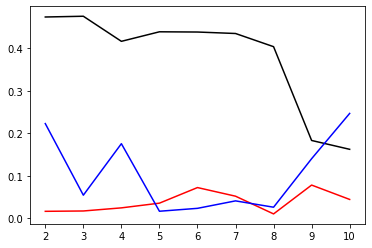

In [58]:
plt.plot(range(2,11), XXTscorelist, c="black",label="XXT")
plt.plot(range(2,11), kdscorelist, c="red",label="kNN")
plt.plot(range(2,11), pscorelist, c="blue",label="PRoNE")


In [59]:
d
#range(2,d)[7]

10

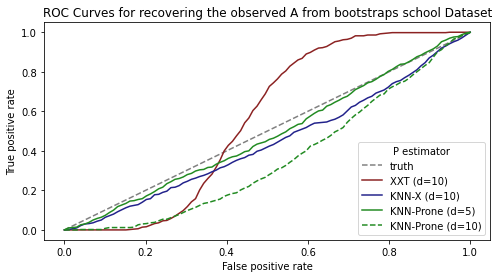

In [60]:
plt.figure().set_figwidth(8)
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey",label="truth")
plt.plot(XXTalphas, XXTroc, color='#8B2222',label="XXT (d=10)")
plt.plot(kalphaslist[1], kroclist[1], color='#22228B',label="KNN-X (d=10)")
plt.plot(palphaslist[4], proclist[4], color='#228B22',label="KNN-Prone (d=5)")
plt.plot(palphaslist[7], proclist[7], color='#228B22',linestyle="--",label="KNN-Prone (d=10)")

# Set title and aspect ratio
plt.title(f"ROC Curves for recovering the observed A from bootstraps school Dataset")
#plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right',title='P estimator')
# Adding axis labels
plt.xlabel('False positive rate')  # Add label to the x-axis
plt.ylabel('True positive rate')

# plt.savefig("school_example_roccurves.png", facecolor='white')

plt.show()

## Examining the different estimates of P

In [61]:
yhatprone = unfolded_prone(dense_adj, d=6, flat=True)
yhatuase = UASE([dense_adj], d=d, flat=True)
n_neighbors=5
# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults),
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors
nbrsprone = NearestNeighbors(
    n_neighbors=n_neighbors, algorithm="ball_tree", metric="minkowski", p=2
).fit(yhatprone)
nbrsuase = NearestNeighbors(
    n_neighbors=n_neighbors, algorithm="ball_tree", metric="minkowski", p=2
).fit(yhatuase)

pronedistances, proneindices = nbrsprone.kneighbors(yhatprone)
uasedistances, uaseindices = nbrsuase.kneighbors(yhatuase)

# Estimate the P matrix -------------------------------
P_estprone = P_est_from_A_obs(n, dense_adj, n_neighbors=n_neighbors, indices=proneindices)
P_estuase = P_est_from_A_obs(n, dense_adj, n_neighbors=n_neighbors, indices=uaseindices)

# Bootstrap -----------------------------------------
#A_est = make_inhomogeneous_rg(P_est)

[0.06260842838603921, 0.06075063178744622, 0.035561777482408116, 0.03525956905653002]


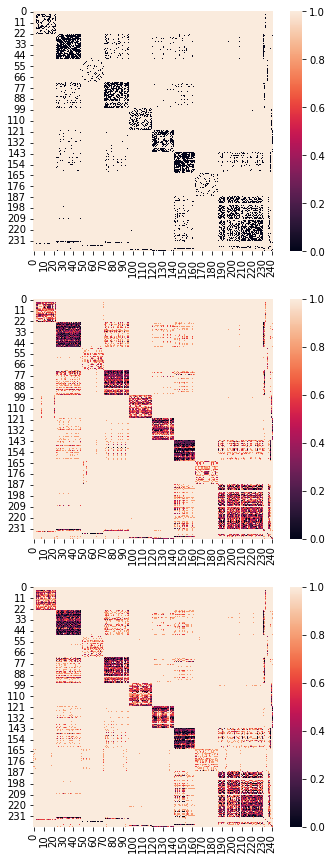

In [62]:
print([np.mean(P_estprone),np.mean(P_estuase),np.var(P_estprone),np.var(P_estuase)])
np.corrcoef(P_estprone.flatten(),P_estuase.flatten())
fig, (ax0,ax1, ax2) = plt.subplots(3, 1, figsize=(6, 15))

sns.heatmap(1-dense_adj, square=True,ax=ax0)
sns.heatmap(1-P_estprone, square=True,ax=ax1)
sns.heatmap(1-P_estuase, square=True,ax=ax2)
plt.show()


## Get the bootstraps from our "Favoured" method

In [77]:
k=5

In [78]:
A_boots_list_prone = []
A_boots_list_knn = []
d_prone=6
for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_prone_bootstrap(dense_adj, d=d_prone, Q=1000, n_neighbors=k)
    A_boots_list_prone.append(A_boots)
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    A_boots_list_knn.append(A_boots)

100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


In [79]:
A_prone_list = [dense_adj] + A_boots_list_prone
A_knn_list = [dense_adj] + A_boots_list_knn

yhat_prone = UASE(A_prone_list, d=d_prone, sparse_matrix=False)
yhat_knn = UASE(A_knn_list, d=d, sparse_matrix=False)

In [80]:
yadflist=[]
for yhat in [yhat_prone,yhat_knn]:
    yadf = pd.DataFrame(yhat)
    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 
    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, B + 1)
    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(B+1), len(labels))
    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)
    yadflist.append(yadf)

## Compute which nodes could be mistaken for which other nodes

In [ ]:
def get_friends(yadf,threshold=3):
    """"create an adjacency matrix of nodes that overlap in uncertainty"""
    n=np.int64(yadf.shape[0]/(1+np.max(yadf["Matrix"])))
    in_cov_friends = np.zeros((n,n))
    
    for i in range(n):
        # Filter data for node number and select the relevant dimensions
        node_number = i
        data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

        # Calculate the mean and covariance considering all d dimensions
        mean_d_dim = np.mean(data_d_dim, axis=0)
        cov_d_dim = np.cov(data_d_dim, rowvar=False)

        # Use the point corresponding to the specific node_number in matrix 0 as the center
        point = data_d_dim[0]
        obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

        # Filter points within the ellipse
        inside_ellipse = points_within_ellipse(obs_points, point, cov_d_dim, threshold=threshold)

        # Extract node numbers for points inside the ellipse
        node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

        # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
        in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
    # minimum means both must be 1
    # maximum means at least one must be 1
    in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
    return(in_cov_friends_symm)

In [88]:
def get_friends(yadf, d, threshold=3):
    """"create an adjacency matrix of nodes that overlap in uncertainty"""
    n = np.int64(yadf.shape[0] / (1 + np.max(yadf["Matrix"])))
    in_cov_friends = np.zeros((n, n))

    for i in range(n):
        # Filter data for node number and select the relevant dimensions
        node_number = i
        data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

        # Calculate the mean and covariance considering all d dimensions
        mean_d_dim = np.mean(data_d_dim, axis=0)
        cov_d_dim = np.cov(data_d_dim, rowvar=False)

        # Use the point corresponding to the specific node_number in matrix 0 as the center
        point = data_d_dim[0]
        obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

        # Filter points within the ellipse
        inside_ellipse = points_within_ellipse(obs_points, point, cov_d_dim, threshold=threshold)

        # Extract node numbers for points inside the ellipse
        node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

        # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
        in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # Symmetrize the matrix in_cov_friends - 
    in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
    return in_cov_friends_symm


In [91]:
in_cov_friends_symm_prone=get_friends(yadflist[0],d=d_prone, threshold=3*6/10) # correction for dimensions differences
in_cov_friends_symm_knn=get_friends(yadflist[1],d=d,threshold=1)
#sns.heatmap(in_cov_friends_symm, square=True)
#print(np.mean(in_cov_friends_symm))

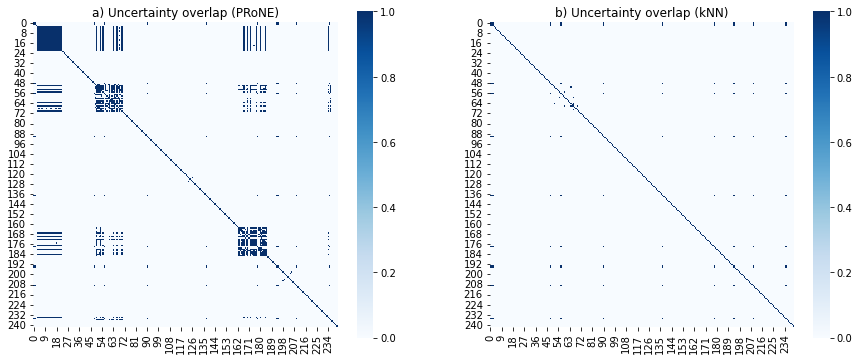

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.color_palette("rocket", as_cmap=True)
sns.heatmap(in_cov_friends_symm_prone, square=True,ax=ax1,cmap='Blues')
sns.heatmap(in_cov_friends_symm_knn, square=True,ax=ax2,cmap='Blues')
ax1.set_title("a) Uncertainty overlap (PRoNE)")
ax2.set_title("b) Uncertainty overlap (kNN)")
# plt.savefig("FigFriendsProneVsKnn_EmeraldCode.png", facecolor='w')
plt.show()
